<a href="https://colab.research.google.com/github/ahmedlabib02/Nlp-project/blob/main/Nlp_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone 1

In [9]:
# %pip install transformers
# %pip install nltk
# %pip install farasapy
# %pip install --quiet camel-tools-data
# %pip install camel-tools
# %pip install camel-tools -f https://download.pytorch.org/whl/torch_stable.html

# %pip install arabic-reshaper
# %pip install python-bidi
# %pip install wordcloud
# %pip install WordCloud
# %pip install --upgrade -f https://download.pytorch.org/whl/torch_stable.html camel-tools
%pip install arabic-reshaper python-bidi


Note: you may need to restart the kernel to use updated packages.


In [105]:
import os 
import zipfile
import json
import re
import pandas as pd
from collections import Counter
import string
from wordcloud import WordCloud
from transformers import BertTokenizer
import nltk
from nltk import ngrams
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from farasa.segmenter import FarasaSegmenter
from nltk.stem.isri import ISRIStemmer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from camel_tools.morphology.database import MorphologyDB
from camel_tools.morphology.analyzer import Analyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import arabic_reshaper
from scipy.sparse import hstack
from bidi.algorithm import get_display
segmenter = FarasaSegmenter(interactive=False)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Ahmed
[nltk_data]     Labib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data preparation

#### Unzipping the channel folders

In [11]:
def unzip(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [12]:
unzip("B_hodoo2.zip", "./")
unzip( "kefaya_ba2a.zip", "./")
unzip("al_mokhbir_al_eqtisadi.zip",'./')

**Al mokhbir channel has different metadata structure so modify the structure to make similar to others**

In [13]:
channel_folder = './al_mokhbir_al_eqtisadi'
metadata_folder = os.path.join(channel_folder, 'metadata')
annotations = []


for filename in os.listdir(metadata_folder):
    if filename.endswith('.json'):
        file_path = os.path.join(metadata_folder, filename)
        with open(file_path, 'r', encoding='utf-8') as f:
            try:
                data = json.load(f)
                data["category"] = data["categories"][0]
                annotations.append(data)
            except Exception as e:
                print(f"Error processing {filename}: {e}")



output_file = os.path.join(channel_folder, 'annotations.json')
with open(output_file, 'w', encoding='utf-8') as f_out:
    json.dump(annotations, f_out, ensure_ascii=False, indent=4)




In [14]:
# os.rename('al_mokhbir_al_eqtisadi/raw_data','al_mokhbir_al_eqtisadi/raw')

### Building dict for annotations and text

**there is a slight inconsistency in the naming of the annotation and the corresponding txt file**

In [15]:
def standardize(title):
    title = title.replace("_", " ").lower()
    title = re.sub(r'ـ+', '', title)
    title = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', title)
    title = re.sub(r'[^\w\s]', '', title)
    title = re.sub(r'\s+', ' ', title).strip()
    return title

In [16]:
def get_category_for_filename(target_filename, annotations_path):
    with open(annotations_path, 'r', encoding='utf-8') as f_json:
        annotations = json.load(f_json)
    
    base_target = os.path.splitext(target_filename)[0]
    target_can = standardize(base_target)
    # print("Target standardized:", target_can)  
    for entry in annotations:
        annotation_title = entry.get('title')
        if annotation_title:
            annotation_can = standardize(annotation_title)
            # print("Annotation standardized:", annotation_can) 
            if annotation_can == target_can:
                return entry.get('category')
    return None

In [17]:
def add_transcripts_from_folder(transcripts_dict, folder_path, channel, max_transcripts=None):
    annotations_json = os.path.join(folder_path, 'annotations.json')
    raw_folder = os.path.join(folder_path, 'raw')
    count = 0
    for filename in os.listdir(raw_folder):
        if max_transcripts is not None and count >= max_transcripts:
            break
        full_path = os.path.join(raw_folder, filename)
        if os.path.isfile(full_path):
            with open(full_path, 'r', encoding='utf-8') as file:
                transcript = file.read()
            category = get_category_for_filename(filename, annotations_json)
            base_filename, _ = os.path.splitext(filename)
            transcripts_dict[base_filename] = (channel, category, transcript)
            count += 1
    return transcripts_dict

In [18]:
transcripts_dict = {}
first_folder_path = './B Hodoo2/'
second_folder_path = './Kefaya Ba2a/'
third_folder_path = './al_mokhbir_al_eqtisadi/'
transcripts_dict = add_transcripts_from_folder(transcripts_dict, first_folder_path,  'B Hodoo2')
transcripts_dict = add_transcripts_from_folder(transcripts_dict, second_folder_path, 'Kefaya Ba2a')
transcripts_dict = add_transcripts_from_folder(transcripts_dict, third_folder_path, 'al mokhbir al eqtisadi',max_transcripts=25)

### Creating a dataframe

In [19]:
data = [(title, info[0], info[1], info[2]) for title, info in transcripts_dict.items()]
df = pd.DataFrame(data, columns=['title', 'channel', 'category', 'transcript'])
print(df.head())


                                               title   channel   category  \
0  أكبر كذبة في التاريخ _ وهم الانتاجية! - _ بودك...  B Hodoo2  Education   
1  إزاي ضاعفت دخلي بدون شغل إضافي! - عن الرزق ووس...  B Hodoo2  Education   
2  اخطر محتوى في العالم! _ بودكاست بهدوء مع كريم ...  B Hodoo2  Education   
3  العيد والنكد - ليه مش بنبسط في العيد؟ _ بودكاس...  B Hodoo2  Education   
4  انا فقير _ اصحابي كلهم أغنى مني! _ بودكاست بهد...  B Hodoo2  Education   

                                          transcript  
0  النهارده الفيديو بتاعنا على\nالانتاجيه لان الن...  
1  انا النهارده جاي اقوللك ازاي تزود من\nدخلك الم...  
2  النهارده انا جاي اتكلم على واحده من اخطر\nالظو...  
3  بصراحه انا موضوع ان احنا مش عارفين نتبسط\nفي ا...  
4  مساء الفل الفيديو ده عن الرزق لو انت\nواحد من ...  


## Initial analysis

**Reveals the number of rows and columns, data types of each column, and non-null counts.**

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       73 non-null     object
 1   channel     73 non-null     object
 2   category    72 non-null     object
 3   transcript  73 non-null     object
dtypes: object(4)
memory usage: 2.4+ KB


**Identifying which columns have missing values**

In [21]:
df.isnull().sum()

title         0
channel       0
category      1
transcript    0
dtype: int64

**Since there are some entries without categories or an annotation file, we just remove them.**

In [22]:
df = df[df['category'].notna()]

**Measuring number of transcript and exploring outliers**

In [23]:
df['raw_length'] = df['transcript'].apply(len)
print(df['raw_length'].describe())

count       72.000000
mean     18706.652778
std       9296.437232
min        370.000000
25%      12356.750000
50%      17220.000000
75%      22676.250000
max      51920.000000
Name: raw_length, dtype: float64


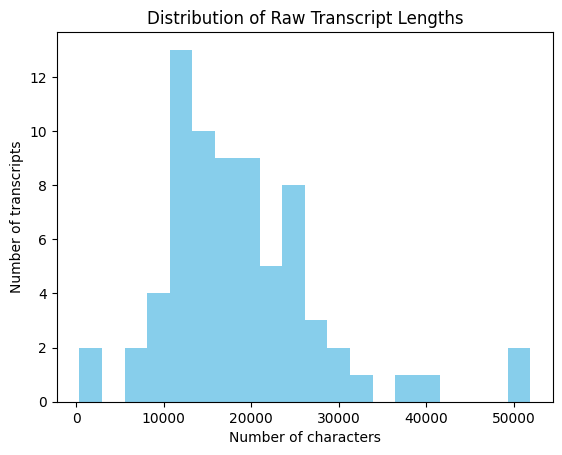

In [ ]:
plt.hist(df['raw_length'], bins=20, color='skyblue')
plt.xlabel("Number of characters")
plt.ylabel("Number of transcripts")
plt.title("Distribution of Raw Transcript Lengths")
plt.show()

category
Education         26
Entertainment     25
People & Blogs    17
Comedy             4
Name: count, dtype: int64


<Axes: title={'center': 'Category Distribution'}, xlabel='category'>

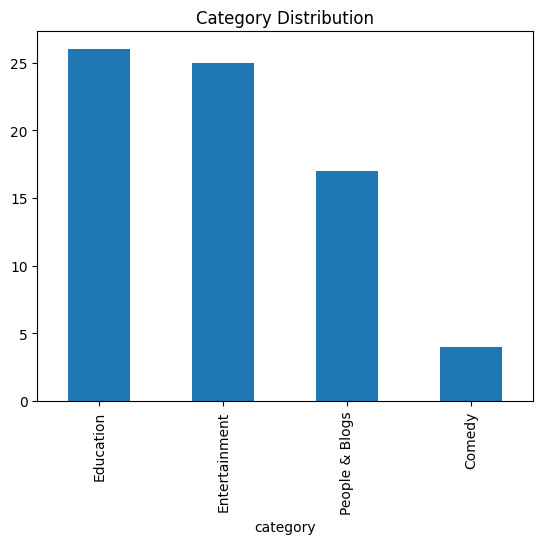

In [25]:
print(df['category'].value_counts())
df['category'].value_counts().plot(kind='bar', title='Category Distribution')

In [26]:
print(df['channel'].unique())
print(df['channel'].value_counts())

['B Hodoo2' 'Kefaya Ba2a' 'al mokhbir al eqtisadi']
channel
B Hodoo2                  26
al mokhbir al eqtisadi    25
Kefaya Ba2a               21
Name: count, dtype: int64


**Viewing most common words before preprocessing**

In [27]:
all_text = " ".join(df['transcript'])
words = all_text.split()
word_freq = Counter(words)
print("Top 10 most common words in raw transcripts:")
print(word_freq.most_common(10))

Top 10 most common words in raw transcripts:
[('في', 8259), ('اللي', 4362), ('من', 4198), ('ما', 3996), ('انا', 3849), ('ده', 3335), ('على', 3139), ('هو', 2928), ('ان', 2918), ('انت', 2864)]


**Viewing the most common words per category**

In [28]:
def top_words_for_category(cat, n=10):
    subset = df[df['category'] == cat]
    combined_text = " ".join(subset['transcript'])
    words = combined_text.split()
    word_counts = Counter(words)
    return word_counts.most_common(n)
categories = df['category'].unique()
for cat in categories:
    print(f"Category: {cat}")
    top_words = top_words_for_category(cat, n=5)
    for word, count in top_words:
        print(f"  {word}: {count}")

Category: Education
  في: 3018
  انا: 2115
  اللي: 1838
  ان: 1789
  من: 1780
Category: People & Blogs
  في: 2135
  انت: 1332
  انا: 1327
  ما: 1285
  هو: 1259
Category: Comedy
  في: 573
  ما: 399
  يا: 391
  انا: 381
  انت: 364
Category: Entertainment
  في: 2533
  من: 1461
  اللي: 1109
  على: 906
  ما: 666


## Pre-Processing

### Cleaning the data

#### Removing numbers, non-Arabic letters and extra spaces

In [ ]:
def clean_text(text):
    
    text = re.sub(r'[إأآا]', 'ا', text)  
    text = re.sub(r'ى', 'ي', text)      
    text = re.sub(r'ؤ', 'و', text)       
    text = re.sub(r'ئ', 'ي', text)       

    
    punctuations = string.punctuation + "[](){}؟،؛«»…ـ"
    translator = str.maketrans('', '', punctuations)
    text = text.translate(translator)
    
    
    text = re.sub(r'[0-9A-Za-z]', '', text)

    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [111]:
df["clean_transcript"] = df["transcript"].apply(clean_text)
print(df.head())

                                               title   channel   category  \
0  أكبر كذبة في التاريخ _ وهم الانتاجية! - _ بودك...  B Hodoo2  Education   
1  إزاي ضاعفت دخلي بدون شغل إضافي! - عن الرزق ووس...  B Hodoo2  Education   
2  اخطر محتوى في العالم! _ بودكاست بهدوء مع كريم ...  B Hodoo2  Education   
3  العيد والنكد - ليه مش بنبسط في العيد؟ _ بودكاس...  B Hodoo2  Education   
4  انا فقير _ اصحابي كلهم أغنى مني! _ بودكاست بهد...  B Hodoo2  Education   

                                          transcript  raw_length  \
0  النهارده الفيديو بتاعنا على\nالانتاجيه لان الن...       21032   
1  انا النهارده جاي اقوللك ازاي تزود من\nدخلك الم...       18261   
2  النهارده انا جاي اتكلم على واحده من اخطر\nالظو...       18546   
3  بصراحه انا موضوع ان احنا مش عارفين نتبسط\nفي ا...       23874   
4  مساء الفل الفيديو ده عن الرزق لو انت\nواحد من ...       11462   

                                    clean_transcript  \
0  النهارده الفيديو بتاعنا على الانتاجيه لان النه...   
1  انا النهارده 

### Tokenization 

In [112]:
def bert_tokenize(df):
    tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
    df['bert_tokens'] = df['clean_transcript'].apply(lambda x: tokenizer.tokenize(str(x)))
bert_tokenize(df)
print(df["bert_tokens"].head())

0    [ال, ##نها, ##رد, ##ه, ال, ##فيد, ##يو, ب, ##ت...
1    [ان, ##ا, ال, ##نها, ##رد, ##ه, جا, ##ي, ا, ##...
2    [ال, ##نها, ##رد, ##ه, ان, ##ا, جا, ##ي, ا, ##...
3    [ب, ##صر, ##اح, ##ه, ان, ##ا, موضوع, ان, ا, ##...
4    [م, ##ساء, ال, ##فل, ال, ##فيد, ##يو, ده, عن, ...
Name: bert_tokens, dtype: object


**We will use more dialect specific tokenizer using libraries like Farasa**

In [113]:
def farasa_tokenize(text):
    text = str(text)
    segmented_text = segmenter.segment(text)
    tokens = segmented_text.split()
    return tokens

df['farasa_tokens'] = df['transcript'].apply(farasa_tokenize)
df['farasa_tokens'] 

0     [النهارده, ال+فيديو, بتاع+نا, على, ال+انتاجيه,...
1     [أنا, النهارده, جاي, اقوللك, ازاي, تزود, من, د...
2     [النهارده, أنا, جاي, اتكلم, على, واحد+ه, من, أ...
3     [ب+صراح+ه, أنا, موضوع, ان, اح+نا, مش, عارف+ين,...
4     [مساء, ال+فل, ال+فيديو, ده, عن, ال+رزق, لو, أن...
                            ...                        
68    [قبل, ثلاث, أيام, ب+ال+ظبط, من, غزو, روسيا, ل+...
69    [عارف+ين, هولندا, ؟, أكيد, عارفين+ها, و+أكيد, ...
70    [في, يناير, 2024, محافظ, ال+بنك, ال+مركزي, ال+...
71    [يوم, 8, مارس, 2023, بنك, Silvergate, ال+أمريك...
72    [اللي, ب+يملك, ال+بطاري+ات, هو, اللي, ب+يملك, ...
Name: farasa_tokens, Length: 72, dtype: object

**Plus signs and square brackets generated with farasa tokenizition which introduce noise so we remove them**

In [142]:
def remove_extra_signs(tokens):
    return [token.replace('+', '').replace('[', '').replace(']', '') for token in tokens]

df['farasa_tokens'] = df['farasa_tokens'].apply(remove_extra_signs)


### Stop word removal

**Analysing the stop word removal in each in transcript**

In [144]:
arabic_stopwords = set(stopwords.words('arabic'))

In [145]:
def count_stopwords(tokens, stopwords_set):
    return sum(1 for token in tokens if token in stopwords_set)

In [146]:
df['total_tokens'] = df['farasa_tokens'].apply(len)

**Removing the stop words**

In [147]:
def remove_stopwords(tokens, stopwords_set):
    return [token for token in tokens if token not in stopwords_set]

In [148]:
df['tokens_no_stop'] = df['farasa_tokens'].apply(lambda tokens: remove_stopwords(tokens, arabic_stopwords))
df['total_tokens_no_stop'] = df['tokens_no_stop'].apply(len)


In [150]:
mean_total_tokens = round(df['total_tokens'].mean(), 1)
mean_total_tokens_no_stop = round(df['total_tokens_no_stop'].mean(), 1)

data = {
    "Metric": [
        "Mean total tokens", 
        "Mean total tokens after stopword removal"
    ],
    "Value": [
        mean_total_tokens, 
        mean_total_tokens_no_stop
    ]
}
table = pd.DataFrame(data)
print(table)

                                     Metric   Value
0                         Mean total tokens  3684.3
1  Mean total tokens after stopword removal  2822.7


**Removing custom egyptian stop words**

In [151]:
vectorizer = TfidfVectorizer(use_idf=True)
tfidf_matrix = vectorizer.fit_transform(df['clean_transcript'])
idf = vectorizer.idf_
terms = vectorizer.get_feature_names_out()
term_idf = list(zip(terms, idf))
common_words = [term for term, score in term_idf if score < np.percentile(idf, 5)]
print("Candidate stopwords based on low IDF:", common_words)


Candidate stopwords based on low IDF: ['أشرف', 'أصلا', 'أكتر', 'أنا', 'أو', 'أول', 'أي', 'إبراهيم', 'إحنا', 'إزاي', 'إن', 'إنه', 'إنها', 'إنهم', 'إيه', 'اب', 'ابتدت', 'ابتدى', 'ابتدي', 'ابتديت', 'ابدا', 'ابراهيم', 'ابسط', 'ابص', 'ابقى', 'ابن', 'ابني', 'ابو', 'ابويا', 'ابيض', 'اتس', 'اتفرج', 'اتكلم', 'اتكلمت', 'اتكلمنا', 'اتمنى', 'اتنين', 'اثر', 'اثنين', 'اجتماع', 'اجري', 'اجي', 'اجيب', 'احد', 'احساس', 'احسن', 'احمد', 'احنا', 'احيانا', 'اختبار', 'اخد', 'اخر', 'اخرج', 'اخرى', 'اخش', 'اخويا', 'اخي', 'ادي', 'اذا', 'ارباع', 'اربع', 'اربعه', 'ارجع', 'ارض', 'اروح', 'از', 'ازاي', 'اس', 'اسئله', 'اساس', 'اساسي', 'اسال', 'استماعكم', 'اسف', 'اسكندريه', 'اسم', 'اسماعيل', 'اسمع', 'اسمه', 'اسمها', 'اشترك', 'اشتركوا', 'اشتغل', 'اشرف', 'اشوف', 'اصحاب', 'اصحابي', 'اصل', 'اصلا', 'اطار', 'اطلع', 'اطول', 'اعتقد', 'اعرف', 'اعرفش', 'اعلم', 'اعلى', 'اعمال', 'اعمل', 'اف', 'افتح', 'افتكر', 'افضل', 'افكار', 'افنت', 'افهم', 'اقدر', 'اقرب', 'اقسم', 'اقعد', 'اقل', 'اقول', 'اقوله', 'اقولها', 'اكبر', 'اكت', 'اكتب', 

In [152]:
egyptian_stopwords = {"انت","يا","قبل","في","علي","عن","الي","من","بلاش",  "ايه",  "يعني",  "أوي",  "اللي","انا","ده" , "مش","دي","بقى", "كده","مالوش","بس","ال", "ان", "عل", "كد", "نا", "بتاع"
}
common_words = common_words + list(egyptian_stopwords)
df['tokens_no_stop_additional'] = df['tokens_no_stop'].apply(lambda tokens: remove_stopwords(tokens, set(common_words)))
df['total_tokens_no_stop_custom'] = df['tokens_no_stop_additional'].apply(len)


In [154]:
mean_total_tokens = df['total_tokens'].mean()
mean_total_tokens_no_stop = df['total_tokens_no_stop'].mean()
mean_total_tokens_no_stop_custom = df['total_tokens_no_stop_custom'].mean()

# Create a table summarizing the results
data = {
    "Metric": [
        "Mean total tokens",
        "Mean tokens after initial stopword removal",
        "Mean tokens after additional stopword removal"
    ],
    "Value": [
        mean_total_tokens,
        mean_total_tokens_no_stop,
        mean_total_tokens_no_stop_custom
    ]
}

summary_table = pd.DataFrame(data)
summary_table

,Metric,Value
0,Mean total tokens,3684.277778
1,Mean tokens after initial stopword removal,2822.736111
2,Mean tokens after additional stopword removal,1277.347222


### Named entity recognition

In [ ]:
from camel_tools.ner import NERecognizer
ner = NERecognizer.pretrained()
def extract_entities(tokens):
    tags = ner.predict_sentence(tokens)
    entities = list(zip(tokens, tags))
    return entities


df['entities'] = df['tokens_no_stop_additional'].apply(extract_entities)


Some weights of the model checkpoint at C:\Users\Ahmed Labib\AppData\Roaming\camel_tools\data\ner\arabert were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,title,entities
0,أكبر كذبة في التاريخ _ وهم الانتاجية! - _ بودك...,"[(الانتاجيه, O), (500, O), (قناه, O), (وبحسبه,..."
1,إزاي ضاعفت دخلي بدون شغل إضافي! - عن الرزق ووس...,"[(اقوللك, O), (تزود, O), (دخلك, O), (المادي, O..."
2,اخطر محتوى في العالم! _ بودكاست بهدوء مع كريم ...,"[(أخطر, O), (الظواهر, O), (العصر, O), (النيوكل..."
3,العيد والنكد - ليه مش بنبسط في العيد؟ _ بودكاس...,"[(نتبسط, O), (العيد, O), (مضايقني, O), (عمالين..."
4,انا فقير _ اصحابي كلهم أغنى مني! _ بودكاست بهد...,"[(مضغوطين, O), (أحيانا, O), (بيضايقك, O), (لأن..."


### Stemming and Lemmatization

**Stemming**

In [155]:
stemmer = ISRIStemmer()
df['stemmed_tokens'] = df['tokens_no_stop_additional'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])
df['stemmed_tokens'][0]

['ناج',
 '500',
 'قنه',
 'حسب',
 'شهد',
 'سبع',
 '12',
 '48',
 'ضرب',
 'ثمن',
 'هيبق',
 '500',
 'مان',
 'نجه',
 'يحق',
 'كلم',
 'ناج',
 'يحق',
 'ليش',
 'كلم',
 'ناج',
 'ضرب',
 'مثل',
 'مثل',
 'رقم',
 'تقل',
 'صحح',
 'كذب',
 'تبع',
 'جيد',
 'سبسكرايب',
 'فعل',
 'جرس',
 'اعل',
 'لزم',
 'زلش',
 'سبع',
 'مان',
 'سبي',
 'رقم',
 'نزل',
 'مري',
 'نزل',
 'سبع',
 'هنت',
 'شغل',
 'تلي',
 'تزم',
 'يدو',
 'سبع',
 'بقم',
 'جيت',
 'جهد',
 'هبد',
 'اقل',
 'ناج',
 'اعل',
 'جنب',
 'دخل',
 'كلش',
 'اصل',
 'ناج',
 'تعل',
 'علم',
 'وأن',
 'قولل',
 'بعل',
 'حطل',
 'رقم',
 'خدع',
 'لنس',
 '5',
 '',
 '7',
 'تسو',
 '12',
 'ضرب',
 '12',
 '3',
 '24',
 'ترح',
 'ديل',
 'ماف',
 'حسب',
 'صحح',
 'وحج',
 '1',
 '1',
 'سسو',
 'ماكدبتش',
 'خبط',
 'رقم',
 'قنع',
 'مخك',
 'سمع',
 'خلف',
 'ناج',
 'وصل',
 '500',
 'ناج',
 'يرج',
 'عقل',
 'خرج',
 'يجب',
 'ثمن',
 'فتر',
 'نزل',
 'فتر',
 'زلش',
 'شهر',
 'خفي',
 'شهر',
 'عمل',
 'يوتيوبرز',
 'هنلعب',
 'ختف',
 'وعد',
 'ككريم',
 'اعل',
 'للل',
 'تثر',
 'سلب',
 'جيت',
 'هنه',
 'جنب'

In [ ]:
db = MorphologyDB.builtin_db('calima-msa-r13', flags='a')
analyzer = Analyzer(db)

def get_lemma(word):
    analyses = analyzer.analyze(word)
    if analyses:
        return analyses[0].get('lemma', word)
    return word
def lemmatize_tokens(tokens):
    """
    Given a list of tokens (from your 'tokens_no_stop' column),
    apply lemmatization to each token and return the list of lemmas.
    """
    return [get_lemma(token) for token in tokens]

df['lemmatized_tokens'] = df['tokens_no_stop_additional'].apply(lemmatize_tokens)


**Comparision between stemming and lemmatization with Manual inspection**

In [46]:
print("Original tokens (from tokens_no_stop_additional):")
print(df.loc[0, 'tokens_no_stop_additional'])

print("\nStemmed tokens:")
print(df.loc[0, 'stemmed_tokens'])


print("\nLemmatized tokens:")
print(df.loc[0, 'lemmatized_tokens'])

Original tokens (from tokens_no_stop_additional):
['الانتاجيه', '500', 'قناه', 'وبحسبه', 'المشاهد', 'أسبوع', '12', '48', 'ضربناهم', 'الثمان', 'هيبقوا', '500', 'ممان', 'منتجه', 'فيحق', 'اكلمك', 'الانتاجيه', 'يحق', 'ليش', 'اكلمك', 'الانتاجيه', 'ضربت', 'المثل', 'المثل', 'الأرقام', 'اتقالت', 'صحيحه', 'كذب', 'متابع', 'جيد', 'سبسكرايب', 'ومفعل', 'الجرس', 'إسماعيل', 'ملتزمه', 'بينزلش', 'أسبوع', 'ممان', 'السبايك', 'الأرقام', 'بنزل', 'استمريت', 'بنزل', 'أسبوع', 'مهنتي', 'شغلتي', 'بالتالي', 'التزم', 'بفيديو', 'أسبوع', 'بقيم', 'انجيتي', 'مجهودي', 'بتهبد', 'أقول', 'انتاجيه', 'إسماعيل', 'نتجنب', 'الدخله', 'الكليشيه', 'أصل', 'الإنتاجات', 'فتعال', 'اعلمك', 'وأنا', 'اقوللك', 'بعلك', 'احطلك', 'أرقام', 'الخدع', 'لناس', '5', '', '7', 'بتساوي', '12', 'اضرب', '12', '3', '24', 'وتروح', 'مديله', 'الماف', 'الحساب', 'وصحيح', 'وحاجه', '1', '1', 'سساوي', 'ماكدبتش', 'يلخبط', 'الأرقام', 'بتقتنع', 'مخك', 'اسمعه', 'الخلفيه', 'الانتاجيه', 'نوصل', '500', 'الانتاجيه', 'يروج', 'عقولنا', 'بمخرجات', 'ايجابيه', 'الثمان', '

**Comparision using vocabulary size**

In [47]:
def vocab_size(tokens):
    vocab = set(tokens)
    token_freq = Counter(tokens)
    print("Vocabulary size:", len(vocab))
    print("Top 10 most frequent lemmas:", token_freq.most_common(10))

In [48]:
all_tokens = [token for tokens in df['tokens_no_stop_additional'] for token in tokens]
vocab_size(all_tokens)

Vocabulary size: 35014
Top 10 most frequent lemmas: [('الإنسان', 338), ('وأنا', 310), ('وأنت', 232), ('؟', 206), ('فأنا', 187), ('الآخر', 176), ('لالله', 171), ('أقول', 162), ('أكبر', 158), ('أعمل', 150)]


In [49]:
all_stemmed_tokens = [token for tokens in df['stemmed_tokens'] for token in tokens]
vocab_size(all_stemmed_tokens)

Vocabulary size: 10109
Top 10 most frequent lemmas: [('عمل', 899), ('امر', 799), ('وأن', 563), ('انس', 454), ('علم', 382), ('عرف', 357), ('اخر', 346), ('سلم', 345), ('جمع', 322), ('فكر', 315)]


In [50]:
all_lemmatized_tokens = [token for tokens in df['lemmatized_tokens'] for token in tokens]
vocab_size(all_lemmatized_tokens)

Vocabulary size: 35014
Top 10 most frequent lemmas: [('الإنسان', 338), ('وأنا', 310), ('وأنت', 232), ('؟', 206), ('فأنا', 187), ('الآخر', 176), ('لالله', 171), ('أقول', 162), ('أكبر', 158), ('أعمل', 150)]


**Comparision using impact on future tasks**

In [209]:
def evaluate_model(text_column):
    X = df[text_column]
    if isinstance(X.iloc[0], list):
        X = X.apply(lambda tokens: " ".join(tokens))  
    y = df['category']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train_vec, y_train)
    
    y_pred = clf.predict(X_test_vec)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cls_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    results = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "classification_report": cls_report,
        "confusion_matrix": conf_matrix
    }
    
    return results


stemmed_results = evaluate_model('stemmed_tokens')
lemmatized_results = evaluate_model('lemmatized_tokens')

print("Results using stemmed text:")
for metric, value in stemmed_results.items():
    print(f"{metric}:")
    print(value)
    print("-" * 40)

print("Results using lemmatized text:")
for metric, value in lemmatized_results.items():
    print(f"{metric}:")
    print(value)
    print("-" * 40)


c:\Users\Ahmed Labib\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ahmed Labib\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ahmed Labib\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Results using stemmed text:
accuracy:
0.8636363636363636
----------------------------------------
precision:
0.8522727272727273
----------------------------------------
recall:
0.8636363636363636
----------------------------------------
f1:
0.8392857142857143
----------------------------------------
classification_report:
                precision    recall  f1-score   support

        Comedy       0.00      0.00      0.00         1
     Education       0.75      1.00      0.86         9
 Entertainment       1.00      1.00      1.00         7
People & Blogs       1.00      0.60      0.75         5

      accuracy                           0.86        22
     macro avg       0.69      0.65      0.65        22
  weighted avg       0.85      0.86      0.84        22

----------------------------------------
confusion_matrix:
[[0 1 0 0]
 [0 9 0 0]
 [0 0 7 0]
 [0 2 0 3]]
----------------------------------------
Results using lemmatized text:
accuracy:
0.8636363636363636
--------------------

c:\Users\Ahmed Labib\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ahmed Labib\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ahmed Labib\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

### Concatenating features

**Features from TF-IDF**

In [ ]:
df['processed_text'] = df['stemmed_tokens'].apply(lambda tokens: " ".join(tokens))
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])
print("TF-IDF matrix shape:", X_tfidf.shape)
feature_names = tfidf_vectorizer.get_feature_names_out()

TF-IDF matrix shape: (72, 5000)


**Extra channel name as feautre**

In [169]:
encoder = OneHotEncoder(sparse_output=True)
X_author = encoder.fit_transform(df[['channel']])  
X_final = hstack([X_tfidf, X_author])
X_final.shape

(72, 5003)

**Encoding targets (category)**

In [159]:
y = df['category'].values
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 3, 3, 0, 3, 3, 3, 0, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2])

## Post Pre-Processing Analysis

#### Analysis on Tf Idf

**Analysing the top 5 tf idf scores for each document**

In [160]:
top_terms_all = []

for doc_index in range(X_tfidf.shape[0]):
    tfidf_scores = X_tfidf[doc_index].toarray().flatten()
    top_indices = np.argsort(tfidf_scores)[::-1][:5]
    top_terms = [(feature_names[i], tfidf_scores[i]) for i in top_indices if tfidf_scores[i] > 0]
    top_terms_all.append(top_terms)


for i, terms in enumerate(top_terms_all):
    print(f"Document {i}:")
    print(f"title: {df['title'].iloc[i]}")
    for term, score in terms:
        print(f"  {term}: {score:.4f}")
    print("------")

Document 0:
title: أكبر كذبة في التاريخ _ وهم الانتاجية! - _ بودكاست بهدوء مع كريم _ جلسة 19
  ناج: 0.5762
  وكس: 0.1332
  نظم: 0.1328
  سوف: 0.1271
  عمل: 0.1243
------
Document 1:
title: إزاي ضاعفت دخلي بدون شغل إضافي! - عن الرزق ووسعه _ بودكاست بهدوء مع كريم _ جلسة 21
  اكس: 0.4096
  عبد: 0.1791
  سعى: 0.1650
  فقر: 0.1593
  رزق: 0.1328
------
Document 2:
title: اخطر محتوى في العالم! _ بودكاست بهدوء مع كريم _ جلسة 13
  بحي: 0.3205
  ولد: 0.2821
  عرض: 0.1700
  ادم: 0.1670
  فرج: 0.1631
------
Document 3:
title: العيد والنكد - ليه مش بنبسط في العيد؟ _ بودكاست بهدوء مع كريم _ جلسة 4
  عيد: 0.7223
  بسط: 0.2154
  جهد: 0.1522
  اضي: 0.1306
  لعب: 0.1272
------
Document 4:
title: انا فقير _ اصحابي كلهم أغنى مني! _ بودكاست بهدوء مع كريم _ جلسة 16
  عقل: 0.2017
  نعم: 0.1967
  ورد: 0.1366
  خلق: 0.1343
  بصش: 0.1263
------
Document 5:
title: تخلص من التعاسة _ بودكاست بهدوء مع كريم _ جلسة 28
  عبد: 0.4489
  تعس: 0.3086
  حرس: 0.1834
  عطى: 0.1817
  سخط: 0.1389
------
Document 6:
title: تخلص

In [161]:
categories = df['category'].dropna().unique()

for cat in categories:
    print(f"Category: {cat}")
    subset = df[df['category'] == cat]
    
    
    vectorizer_cat = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
    X_cat = vectorizer_cat.fit_transform(subset['processed_text'])
    
    feature_names_cat = vectorizer_cat.get_feature_names_out()
    avg_tfidf = np.array(X_cat.mean(axis=0)).flatten()
    
    
    top_indices = np.argsort(avg_tfidf)[::-1][:5]
    top_terms = [(feature_names_cat[i], avg_tfidf[i]) for i in top_indices if avg_tfidf[i] > 0]
    
    for term, score in top_terms:
        print(f"  {term}: {score:.4f}")
    print("------")

Category: Education
  عمل: 0.1056
  وأن: 0.0922
  انس: 0.0889
  علم: 0.0604
  فكر: 0.0548
------
Category: People & Blogs
  عمل: 0.0806
  كلب: 0.0561
  فطر: 0.0551
  اكل: 0.0517
  وأن: 0.0507
------
Category: Comedy
  لعب: 0.2207
  ريض: 0.1605
  مسم: 0.1152
  عمل: 0.1085
  حلق: 0.0953
------
Category: Entertainment
  روس: 0.1052
  امر: 0.1022
  صنع: 0.0461
  صين: 0.0455
  نفط: 0.0379
------


**Visualizing tf-idf matrix by reducing dimension using PCA**

In [213]:
def draw_pca(input):
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(input.toarray())


    plt.figure(figsize=(10, 8))
    categories = df['category'].unique()
    colors = ['red', 'green', 'blue', 'orange']  # Adjust or add colors as needed

    for cat, color in zip(categories, colors):
        idx = df['category'] == cat
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1], c=color, label=cat, alpha=0.6)

    plt.legend()
    plt.title("PCA Visualization of Documents")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

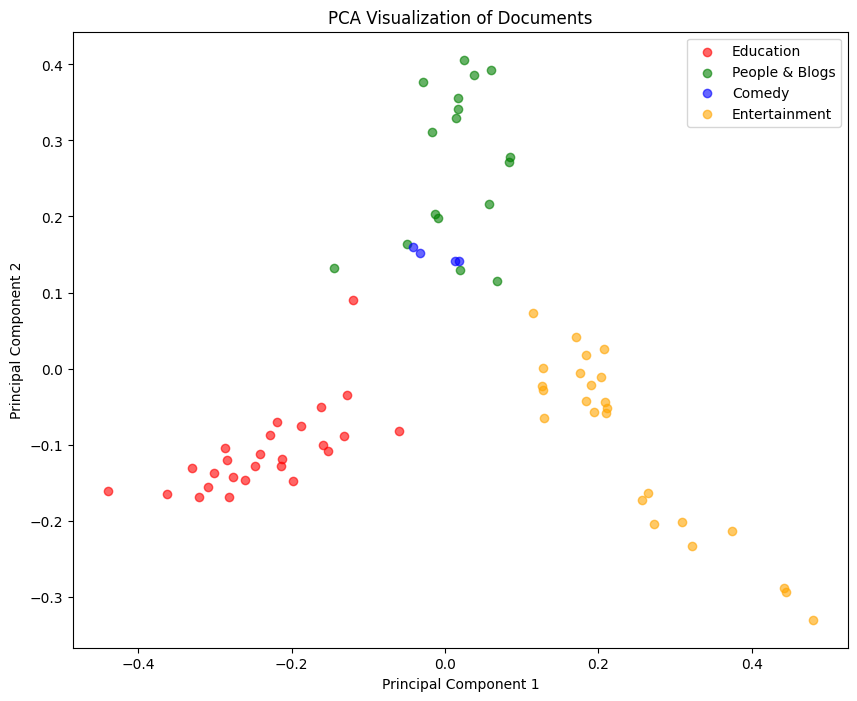

In [214]:
draw_pca(X_tfidf)

**PCA with extra meta data features**

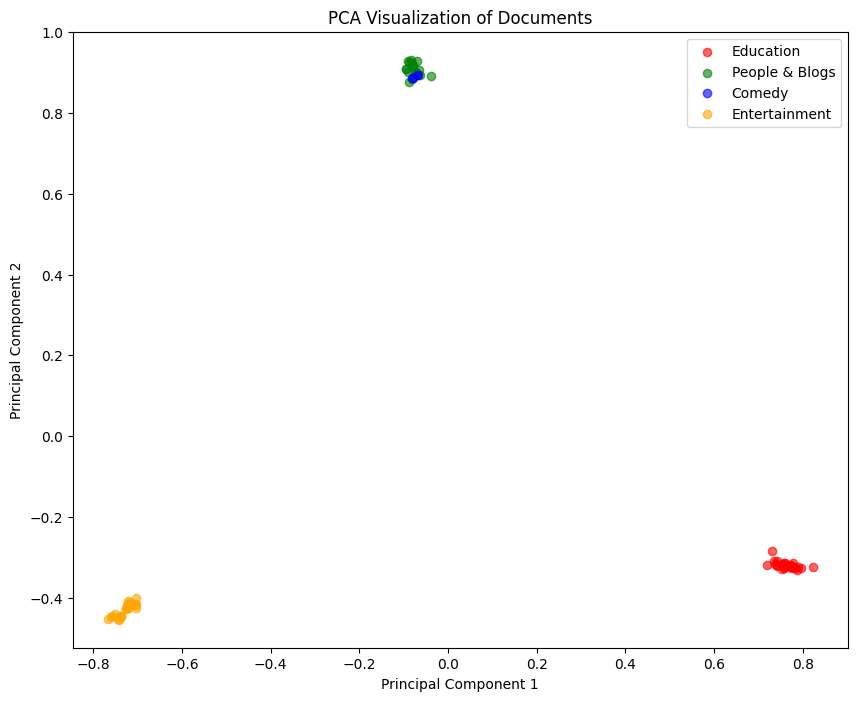

In [206]:
draw_pca(X_final)

#### Word cloud

In [163]:
def generate_category_wordcloud(category, df, font_path="NotoSansArabic-VariableFont_wdth,wght.ttf", width=1000, height=400, background_color='white'):
    """
    Generates and displays a word cloud for a given category.
    
    Parameters:
      - category: The category for which the word cloud is generated.
      - df: DataFrame containing 'category' and 'processed_text' columns.
      - font_path: Path to an Arabic-capable font.
      - width: Width of the generated word cloud.
      - height: Height of the generated word cloud.
      - background_color: Background color for the word cloud.
    """
    
    
    subset = df[df['category'] == category]
    
    
    text_combined = " ".join(subset['processed_text'])
    
    
    reshaped_text = arabic_reshaper.reshape(text_combined)
    bidi_text = get_display(reshaped_text)
    
    # Generate the word cloud
    wordcloud = WordCloud(
        font_path=font_path,
        width=width,
        height=height,
        background_color=background_color
    ).generate(bidi_text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud of Arabic Text for Category: {category}")
    plt.show()


**Entertainment word cloud** 

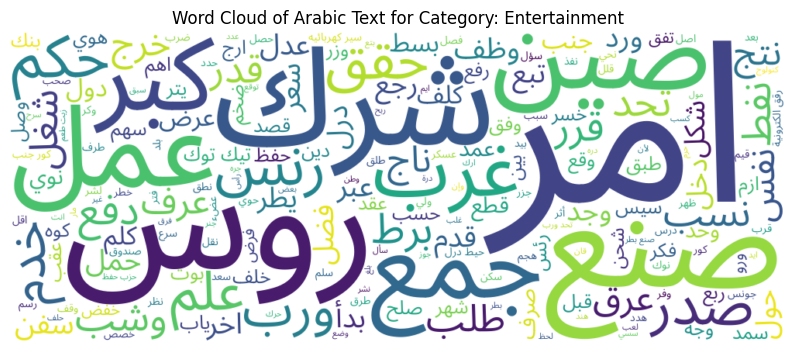

In [ ]:
generate_category_wordcloud('Entertainment',df)

**Comedy word cloud**

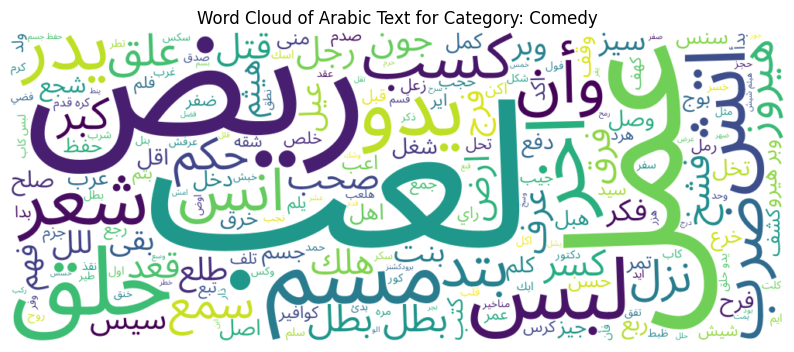

In [ ]:
generate_category_wordcloud('Comedy',df)

**Education word cloud**

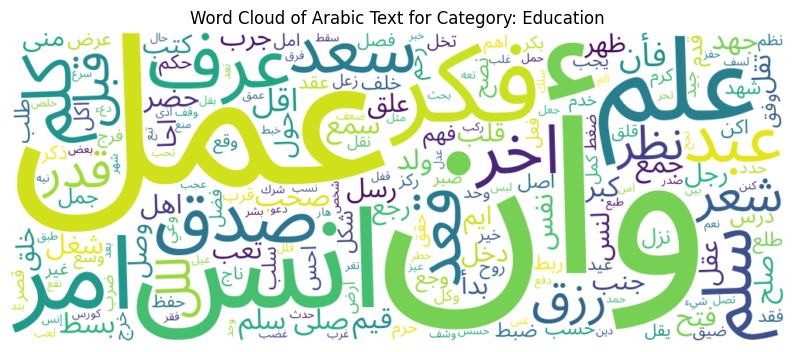

In [ ]:
generate_category_wordcloud('Education',df)

**People and blogs word cloud**

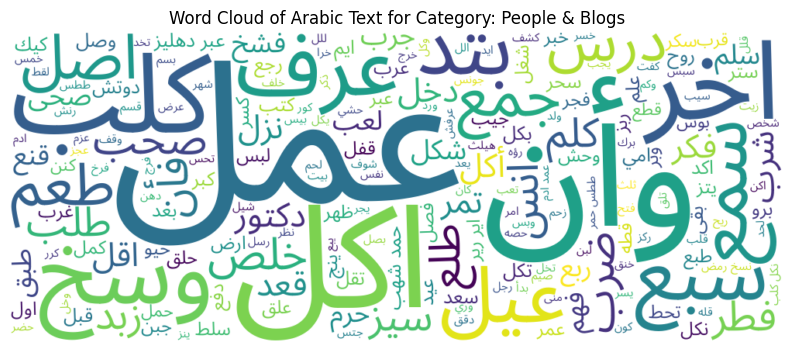

In [ ]:
generate_category_wordcloud('People & Blogs',df)

### Analysing bigrams and anagrams

In [ ]:
def extract_ngrams_from_text(text, n):
    tokens = text.split()
    return list(ngrams(tokens, n))


categories = df['category'].unique()

for cat in categories:
    print(f"Category: {cat}")
    
    
    combined_text = " ".join(df[df['category'] == cat]['processed_text'])
    
    
    cat_bigrams = extract_ngrams_from_text(combined_text, 2)
    cat_trigrams = extract_ngrams_from_text(combined_text, 3)
    
    
    bigram_freq = Counter(cat_bigrams)
    trigram_freq = Counter(cat_trigrams)
    
    print("Top 10 most common bigrams:")
    print(bigram_freq.most_common(5))
    
    print("\nTop 10 most common trigrams:")
    print(trigram_freq.most_common(5))
    print("-" * 50)


Category: Education
Top 10 most common bigrams:
[(('صلى', 'سلم'), 110), (('عمل', 'عمل'), 24), (('صدق', 'صدق'), 24), (('رسل', 'صلى'), 22), (('وأن', 'وأن'), 15)]

Top 10 most common trigrams:
[(('رسل', 'صلى', 'سلم'), 21), (('صدق', 'صدق', 'صدق'), 7), (('غفر', 'ابا', 'بكر'), 6), (('بسط', 'لمن', 'يشء'), 6), (('حفظ', 'حفظ', 'حفظ'), 5)]
--------------------------------------------------
Category: People & Blogs
Top 10 most common bigrams:
[(('عبر', 'دهليز'), 38), (('حمد', 'شهب'), 33), (('اير', 'رير'), 25), (('نسخ', 'رمض'), 24), (('ططس', 'حمر'), 23)]

Top 10 most common trigrams:
[(('كلب', 'حمد', 'شهب'), 10), (('نسخ', 'رمض', 'نسخ'), 8), (('رمض', 'نسخ', 'أصحاب'), 8), (('نسخ', 'أصحاب', 'قلب'), 8), (('أصحاب', 'قلب', 'يحس'), 8)]
--------------------------------------------------
Category: Comedy
Top 10 most common bigrams:
[(('بطل', 'بطل'), 22), (('وبر', 'هيرو'), 11), (('كره', 'قدم'), 9), (('لعب', 'ريض'), 8), (('يدو', 'حلق'), 8)]

Top 10 most common trigrams:
[(('بطل', 'بطل', 'بطل'), 14), (('دام',

### Validating our Pre-Processing using a machine learning model

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_encoded, test_size=0.3, random_state=42)


model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_pred


accuracy = accuracy_score(y_test, y_pred)
unique_labels = np.unique(y_test)
target_names = le.inverse_transform(unique_labels)
report = classification_report(y_test, y_pred, labels=unique_labels, target_names=target_names)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9545454545454546
Classification Report:
                 precision    recall  f1-score   support

        Comedy       0.00      0.00      0.00         1
     Education       1.00      1.00      1.00         9
 Entertainment       1.00      1.00      1.00         7
People & Blogs       0.83      1.00      0.91         5

      accuracy                           0.95        22
     macro avg       0.71      0.75      0.73        22
  weighted avg       0.92      0.95      0.93        22



c:\Users\Ahmed Labib\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ahmed Labib\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ahmed Labib\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

### Analysis on NER per category

In [229]:



def count_entity_tokens(entities):
    counts = Counter()
    for token, tag in entities:
        if tag != "O":  # Only consider tokens that were recognized as entities
            counts[token] += 1
    return counts

# Apply the function to create a new column with entity token counts per document
df['entity_tokens'] = df['entities'].apply(count_entity_tokens)

# Group by category and aggregate the entity token counts
category_entity_tokens = {}

for category, group in df.groupby('category'):
    aggregated = Counter()
    for token_counter in group['entity_tokens']:
        aggregated.update(token_counter)
    category_entity_tokens[category] = aggregated

# Display the top 10 common entities for each category
for cat, counter in category_entity_tokens.items():
    print(f"Category: {cat}")
    for token, count in counter.most_common(10):
        print(f"  {token}: {count}")
    print("")


Category: Comedy
  ميدو: 41
  هيثم: 19
  حسين: 8
  هيروز: 7
  سبايدر: 6
  سوزي: 6
  سوبر: 5
  هنسميها: 5
  شيشه: 5
  هريدي: 4

Category: Education
  بكر: 24
  نوح: 14
  بن: 13
  الإسلام: 11
  إسماعيل: 8
  صلى: 8
  وسلم: 7
  اونلاين: 6
  أحمد: 5
  يوتيوب: 5

Category: Entertainment
  أمريكا: 34
  روسيا: 29
  الاحتياطي: 28
  الأمريكية: 22
  بوتين: 22
  صندوق: 19
  الأمريكي: 18
  كوريا: 17
  توشيبا: 17
  بريطانيا: 15

Category: People & Blogs
  أحمد: 40
  شهاب: 34
  كيك: 25
  تشيز: 19
  خالد: 16
  الكانتين: 15
  زكي: 14
  فراير: 13
  أمريكا: 11
  بيتزا: 10



**Counts of types of entities per category**

In [ ]:
def count_entity_types(entities):
    counts = Counter()
    for token, tag in entities:
       
        if tag != "O":
            counts[tag] += 1
    return counts

df['entity_type_counts'] = df['entities'].apply(count_entity_types)

category_entity_type_counts = {}

for category, group in df.groupby('category'):
    aggregated = Counter()
    for type_counts in group['entity_type_counts']:
        aggregated.update(type_counts)
    category_entity_type_counts[category] = aggregated

for cat, counts in category_entity_type_counts.items():
    print(f"Category: {cat}")
    for entity_type, count in counts.items():
        print(f"  {entity_type}: {count}")
    print("")

Category: Comedy
  B-MISC: 184
  B-LOC: 31
  B-ORG: 70
  I-ORG: 33
  B-PERS: 155
  I-MISC: 42
  I-PERS: 66

Category: Education
  B-PERS: 232
  I-PERS: 117
  B-LOC: 38
  B-ORG: 51
  I-ORG: 31
  I-MISC: 30
  B-MISC: 173
  I-LOC: 2

Category: Entertainment
  B-LOC: 1233
  B-PERS: 583
  B-ORG: 618
  I-ORG: 312
  I-PERS: 270
  I-LOC: 75
  B-MISC: 229
  I-MISC: 58

Category: People & Blogs
  B-MISC: 652
  I-MISC: 83
  B-LOC: 93
  B-ORG: 212
  B-PERS: 358
  I-PERS: 276
  I-ORG: 160
  I-LOC: 2

